In [1]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [2]:
customers = pd.read_csv('Customers.csv')
transactions = pd.read_csv('Transactions.csv')

In [3]:
# merge and aggregate 
transactions_agg = transactions.groupby('CustomerID').agg(
    total_spent=('TotalValue', 'sum'),
    transaction_count=('TransactionID', 'count'),
    avg_transaction_value=('TotalValue', 'mean'),
    product_count=('ProductID', 'nunique')
).reset_index()

In [4]:
data = customers.merge(transactions_agg, on='CustomerID', how='left')


In [5]:
data.fillna(0, inplace=True)


In [6]:
data = pd.get_dummies(data, columns=['Region'], drop_first=True)


In [7]:
features = ['total_spent', 'transaction_count', 'avg_transaction_value', 'product_count'] + \
           [col for col in data.columns if 'Region_' in col]
X = data[features]

In [8]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [9]:
db_scores = []
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    db_index = davies_bouldin_score(X_scaled, kmeans.labels_)
    db_scores.append((k, db_index))

In [10]:
optimal_k = min(db_scores, key=lambda x: x[1])[0]
print(f"Optimal number of clusters: {optimal_k}")

Optimal number of clusters: 10


In [11]:
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
clusters = kmeans.fit_predict(X_scaled)


In [12]:
data['Cluster'] = clusters


In [13]:
final_db_index = davies_bouldin_score(X_scaled, clusters)
print(f"Davies-Bouldin Index for optimal clusters: {final_db_index}")

Davies-Bouldin Index for optimal clusters: 0.9804666619729152


In [14]:
data[['CustomerID', 'Cluster']].to_csv('Customer_Clusters.csv', index=False)


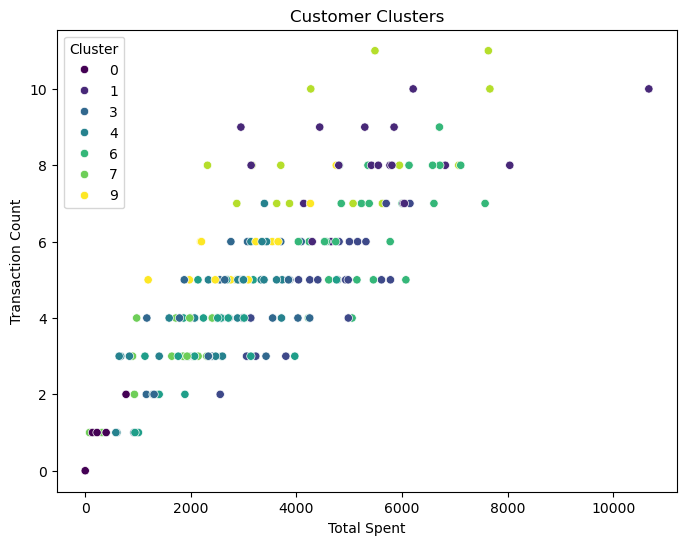

In [15]:
plt.figure(figsize=(8, 6))
sns.scatterplot(
    x=data['total_spent'], y=data['transaction_count'], hue=data['Cluster'], palette='viridis'
)
plt.title('Customer Clusters')
plt.xlabel('Total Spent')
plt.ylabel('Transaction Count')
plt.legend(title='Cluster')
plt.show()

In [16]:
# Save cluster labels to CSV
data[['CustomerID', 'Cluster']].to_csv('Customer_Clusters.csv', index=False)
print("Cluster labels saved to 'Customer_Clusters.csv'.")

Cluster labels saved to 'Customer_Clusters.csv'.


In [17]:
with open('Clustering_Metrics.txt', 'w') as metrics_file:
    metrics_file.write(f"Optimal number of clusters: {optimal_k}\n")
    metrics_file.write(f"Davies-Bouldin Index: {final_db_index:.4f}\n")
print("Clustering metrics saved to 'Clustering_Metrics.txt'.")

Clustering metrics saved to 'Clustering_Metrics.txt'.
